# Continuous Mountain Car with DDPG
This notebook gives an example of a DDPG model which learns to play [Continuous Mountain Car](https://gym.openai.com/envs/MountainCarContinuous-v0/). A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum. Here, the reward is greater if you spend less energy to reach the goal.

## Deep Deterministic Policy Gradient
We'll construct our agent following the guidlines provided in the original DDPG paper, [Continuous Control With Deep Reinforcement Learning by Lillicrap, et al.](https://arxiv.org/pdf/1509.02971.pdf)

## The Environment
We'll use Open AI's [Gym](https://gym.openai.com/) library, and Tensorflow to implement the algorithm. As the name implies, this is a continuous environment, so the action (which is the force applied to the car) can be any number in the range $[-1,1]$. The state consists of the location and velocity of the car. More information is available on the environment's [GitHub page](https://github.com/openai/gym/blob/master/gym/envs/classic_control/continuous_mountain_car.py).

In [1]:
import gym
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque

Setting up the environment:

In [2]:
env = gym.make('MountainCarContinuous-v0')
state_size = env.observation_space.shape[0]

## The Critic
As our critic, we'll use an off-policy version of [Sarsa](https://en.wikipedia.org/wiki/State%E2%80%93action%E2%80%93reward%E2%80%93state%E2%80%93action). It will be off-policy as the transition to the next state $s'$ might be the result of an older policy. The authors also suggested to use L2 regularization with for the critic, but we won't use it for this demo (the code is Implemented, we'll simply set $\lambda = 0$).

In [3]:
class QNetwork:
    def __init__(self, hidden_layers_size, gamma, learning_rate, input_size, name, reg_lambda):
        self.q_target = tf.placeholder(shape=None, dtype=tf.float32, name='dqn_%s_q_target' % name)
        self.r = tf.placeholder(shape=None,dtype=tf.float32, name='dqn_%s_r' % name)
        self.actions = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='dqn_%s_actions' % name)
        self.states = tf.placeholder(shape=(None, input_size), dtype=tf.float32, name='dqn_%s_states' % name)
        
        _layer = tf.concat([self.states, self.actions], axis=1)
        for i in range(len(hidden_layers_size)):
            l = hidden_layers_size[i]
            _layer = tf.layers.dense(inputs=_layer, units=l, activation=tf.nn.relu,
                                     kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                     name='dqn_{n}_layer_{i}'.format(n=name, i=i))
        self.predictions = tf.layers.dense(inputs=_layer, units=1, activation=None,  # Linear activation
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           name='dqn_%s_last_layer' % name) 
        
        self.labels = self.r + gamma * self.q_target
        self.l2 = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables() 
                            if 'bias' not in v.name and 'dqn_%s' % name in v.name])
        self.cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=self.labels, predictions=self.predictions))
        self.cost = self.cost + reg_lambda * self.l2
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

## The Actor
The actor is a Deterministic Policy Gradient (DPG) model, which means it outputs a specific action to perform rather than a probability to select each action. 

Notice the cost function doesn't contiain any $log$. This is due to the fact that this is a DPG. Remember that: $$\nabla\ln(\pi(a|s)) = \frac{\nabla\pi(a|s)}{\pi(a|s)}$$
But since this is a deterministic model, $\pi(a|s)$ is always $1$ for the selected action (and $0$ for all the rest). We are therefore left only with $\nabla\pi(s|a)$, which is simply the gradient of the predicted actions.

Read more about DPG on the original [DPG paper by Silver, et al](http://proceedings.mlr.press/v32/silver14.pdf).

In [4]:
class PolicyGradient:
    def __init__(self, hidden_layers_size, gamma, learning_rate, input_size, min_value, max_value, name):
        self.states = tf.placeholder(shape=(None, input_size), dtype=tf.float32, name='pg_states')
        self.q = tf.placeholder(shape=None, dtype=tf.float32, name='pg_q') 
        self.actions = tf.placeholder(shape=None, dtype=tf.float32, name='pg_actions')
                
        _layer = self.states
        for i in range(len(hidden_layers_size)):
            l = hidden_layers_size[i]
            _layer = tf.layers.dense(inputs=_layer, units=l, activation=tf.nn.relu,
                                     kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                     name='pg_{n}_layer_{i}'.format(n=name, i=i))
        self.predictions = tf.layers.dense(inputs=_layer, units=1, activation=None, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           name='pg_%s_last_layer' % name) 
        
        self.predictions = tf.clip_by_value(self.predictions, min_value, max_value)
        self.cost = tf.reduce_mean(self.q * self.predictions) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

## Experience Replay Memory
We'll use a cyclical buffer as the Experience Replay memory, as suggested in the origianl DDPG paper.

In [5]:
class ReplayMemory:
    def __init__(self, size):
        self.memory = deque(maxlen=size)
        self.counter = 0
        
    def __len__(self):
        return len(self.memory)

    def append(self, element):
        self.memory.append(element)
        self.counter += 1

    def sample(self, n):
        if n > len(self.memory): n = len(self.memory)
        return random.sample(self.memory, n)

## Exploration Noise
As the our model predict a specific action rather than a probability, we need to add some noise to the predicted action in order to allow the model to explore. The authors of the DDPG paper used the [Ornstein–Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) as their noise generator. We'll use the same noise, with the same parameters ($\theta = 0.15, \sigma = 0.2$). As the actions vary in the range $[-1,1]$, we'll set $\mu = 0$. We'll use the [Euler–Maruyama method](https://math.stackexchange.com/a/1288406/535485) to compiute the noise, setting $\Delta t = 1$ for convenience.

In [6]:
class OUNoise:
    def __init__(self, mu, theta, sigma):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()
        
    def reset(self):
        self.x = self.mu
        
    def noise(self):  # dt = 1
        dx = self.theta * (self.mu - self.x) + self.sigma * np.random.normal()
        self.x += dx
        return self.x

## DDPG
Time to plug everything together, and some functionality. The network copying phase is quite computationally expensive, so in order to speed things up, we'll alter the $\tau$ factor found in the networks update rule:
$$\theta' \leftarrow \tau\theta + (1-\tau)\theta'$$
The paper suggests performing this update after every epoch for stability using $\tau << 1$ (the authors suggested $\tau = 10^{-3}$). We'll perform the update every 1000 epochs, and set $\tau = 1$.

In [7]:
class ActorCritic:
    def __init__(self, input_size, memory_size, actor_hidden_layers_size, critic_hidden_layers_size, 
                 actor_gamma, critic_gamma, critic_reg_lambda, 
                 actor_learning_rate, critic_learning_rate, tau, epochs_to_copy_target, ou_mu, ou_theta, ou_sigma):
        self.critic = QNetwork(critic_hidden_layers_size, critic_gamma, critic_learning_rate, input_size,
                               name='online', reg_lambda=critic_reg_lambda)
        self.actor = PolicyGradient(actor_hidden_layers_size, actor_gamma, actor_learning_rate, input_size,
                                    min_value=env.action_space.low[0], max_value=env.action_space.high[0],
                                    name='online')
        self.critic_target = QNetwork(critic_hidden_layers_size, critic_gamma, critic_learning_rate, input_size,
                                      name='target', reg_lambda=critic_reg_lambda)
        self.actor_target = PolicyGradient(actor_hidden_layers_size, actor_gamma, actor_learning_rate, input_size,
                                           min_value=env.action_space.low[0], max_value=env.action_space.high[0],
                                           name='target')
        self.memory = ReplayMemory(memory_size)
        self.tau = tau
        self.ou = OUNoise(mu=ou_mu, theta=ou_theta, sigma=ou_sigma)
        self.epoch_counter = 0
        self.epochs_to_copy_target = epochs_to_copy_target
    
    def _extract_from_batch(self, batch, key):
        return np.array(list(map(lambda x: x[key], batch)))
    
    def _update_terminal_states(self, q_target, terminals):
        for i in range(len(terminals)):
            if terminals[i]:
                q_target[i] = 0.0 
        return q_target
    
    def _copy_networks(self, session):
        tf_vars = tf.trainable_variables()
        num_of_vars = len(tf_vars)
        operations = []
        for i, v in enumerate(tf_vars[0:num_of_vars // 2]):
            operations.append(tf_vars[i + num_of_vars // 2].assign(
                (v.value() * self.tau) + ((1 - self.tau) * tf_vars[i + num_of_vars // 2].value())))
        session.run(operations)
          
    def reset_noise(self):
        self.ou.reset()
    
    def remember(self, **kwargs):
        self.memory.append(kwargs)

    def act(self, session, state, greedy=False):
        if greedy:
            action = session.run(self.actor.predictions, feed_dict={self.actor.states: np.expand_dims(state, axis=0)}).flatten()
        else:
            action = session.run(self.actor.predictions, feed_dict={self.actor.states: np.expand_dims(state, axis=0)}).flatten()
            action += self.ou.noise()
        return action
    
    def learn(self, session, batch_size):
        self.epoch_counter += 1
        if len(self.memory) >= batch_size:
            batch = self.memory.sample(batch_size)
            next_states = self._extract_from_batch(batch, 'next_state')
            states = self._extract_from_batch(batch, 'state')
            rewards = self._extract_from_batch(batch, 'reward')
            actions = self._extract_from_batch(batch, 'action')
            terminals = self._extract_from_batch(batch, 'game_over')

            next_actions = session.run(self.actor_target.predictions, feed_dict={self.actor_target.states: next_states})
            q_t = session.run(self.critic_target.predictions, feed_dict={self.critic_target.states: next_states,
                                                                         self.critic_target.actions: next_actions})
            q_t = self._update_terminal_states(q_t, terminals=terminals)
            q = session.run(self.critic.predictions, feed_dict={self.critic.states: states,
                                                                self.critic.actions: actions})

            actor_cost, _, critic_cost, _ = session.run([self.actor.cost, self.actor.optimizer, 
                                                         self.critic.cost, self.critic.optimizer], 
                                                        feed_dict={self.actor.states: states,
                                                                   self.actor.q: q,
                                                                   self.actor.actions: actions,
                                                                   self.critic.q_target: q_t, 
                                                                   self.critic.r: rewards,
                                                                   self.critic.actions: actions,
                                                                   self.critic.states: states})
            if np.isnan(actor_cost) or np.isnan(critic_cost): raise Exception('NaN cost!')
            if self.epoch_counter % self.epochs_to_copy_target == 0: self._copy_networks(session)
            return actor_cost, critic_cost
        else:
            return 0, 0

Let's set-up our hyper-parameters as explained above. We'll use two shallow networks (only a single hidden layer) for the Actor and a little deeper network with two hidden layers for the Critic. We'll also have to set up the Experience Replay memory size and set the batch size. 

In [8]:
# Hyperparameters
actor_hidden_layers = [36]
critic_hidden_layers = [24]
actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
critic_reg_lambda = 0.0  # no regularization
gamma = 0.99
batch_size = 100
memory_size = batch_size * 10

# Running-time optimization
epochs_to_copy_target = 1000
tau = 1

# Ornstein–Uhlenbeck noise parameters
ou_mu = 0
ou_theta = 0.15
ou_sigma = 0.2

Let's set-up our agent:

In [9]:
sess = tf.Session()
ac = ActorCritic(input_size=state_size, memory_size=memory_size, 
                 actor_hidden_layers_size=actor_hidden_layers, critic_hidden_layers_size=critic_hidden_layers, 
                 actor_gamma=gamma, critic_gamma=gamma, critic_reg_lambda=critic_reg_lambda,
                 actor_learning_rate=actor_learning_rate, critic_learning_rate=critic_learning_rate, 
                 tau=tau, epochs_to_copy_target=epochs_to_copy_target,
                 ou_mu=ou_mu, ou_theta=ou_theta, ou_sigma=ou_sigma)

In [10]:
game_df = pd.DataFrame(columns=['game','steps','actor_cost','critic_cost'])
sess.run(tf.global_variables_initializer())

Training time!

In [11]:
def print_stuff(s, every=10):
    if game % every == 0 or game == 1:
        print(s)

In [12]:
games = 1000

for g in range(games):
    game = g + 1
    game_over = False
    next_state = env.reset()
    steps = 0
    ac.reset_noise()
    while not game_over:
        steps += 1
        state = np.copy(next_state)
        action = ac.act(sess, state)
        next_state, r, game_over, _ = env.step(action)
        ac.remember(state=state, action=action, reward=r, next_state=next_state, game_over=game_over)
        actor_cost, critic_cost = ac.learn(sess, batch_size)
    print_stuff('Game {g} ended after {s} steps | Actor cost: {a:.2e}, Critic cost: {c:.2e}'.format(g=game, s=steps, a=actor_cost, c=critic_cost))
    game_df = game_df.append({'game':game, 'steps':steps, 'actor_cost':actor_cost, 'critic_cost':critic_cost}, 
                             ignore_index=True)

Game 1 ended after 919 steps | Actor cost: -1.28e-01, Critic cost: 1.43e-03
Game 10 ended after 579 steps | Actor cost: -3.72e-01, Critic cost: 1.00e+02
Game 20 ended after 649 steps | Actor cost: -7.43e-01, Critic cost: 1.00e+02
Game 30 ended after 999 steps | Actor cost: -8.98e-01, Critic cost: 1.03e-02
Game 40 ended after 816 steps | Actor cost: -1.11e+00, Critic cost: 1.56e-02
Game 50 ended after 391 steps | Actor cost: -1.72e+00, Critic cost: 7.38e-03
Game 60 ended after 448 steps | Actor cost: -1.87e+00, Critic cost: 1.35e-02
Game 70 ended after 800 steps | Actor cost: -1.77e+00, Critic cost: 3.83e-02
Game 80 ended after 684 steps | Actor cost: -1.60e+00, Critic cost: 1.00e+02
Game 90 ended after 926 steps | Actor cost: -2.13e+00, Critic cost: 6.15e-03
Game 100 ended after 863 steps | Actor cost: -2.71e+00, Critic cost: 1.00e+02
Game 110 ended after 326 steps | Actor cost: -2.84e+00, Critic cost: 6.74e-03
Game 120 ended after 999 steps | Actor cost: -2.92e+00, Critic cost: 1.62e-

Let's see how well the Agent learned:

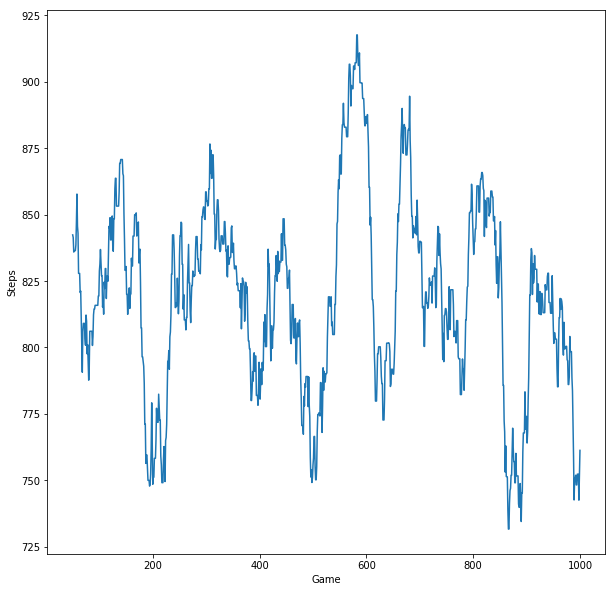

In [13]:
game_df['steps_moving_average'] = game_df['steps'].rolling(window=50).mean()
ax = game_df.plot('game','steps_moving_average', figsize=(10,10), legend=False)
ax.set_xlabel('Game')
ax.set_ylabel('Steps')
plt.show()

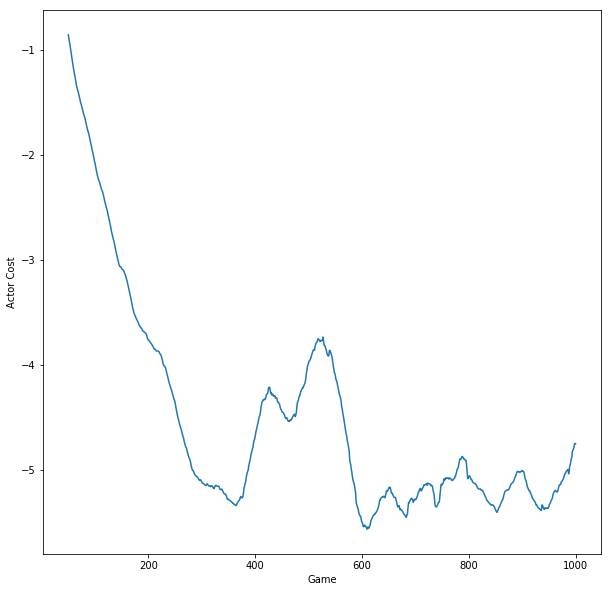

In [14]:
game_df['actor_cost_moving_average'] = game_df['actor_cost'].rolling(window=50).mean()
ax = game_df.plot('game','actor_cost_moving_average', figsize=(10,10), legend=False)
ax.set_xlabel('Game')
ax.set_ylabel('Actor Cost')
plt.show()

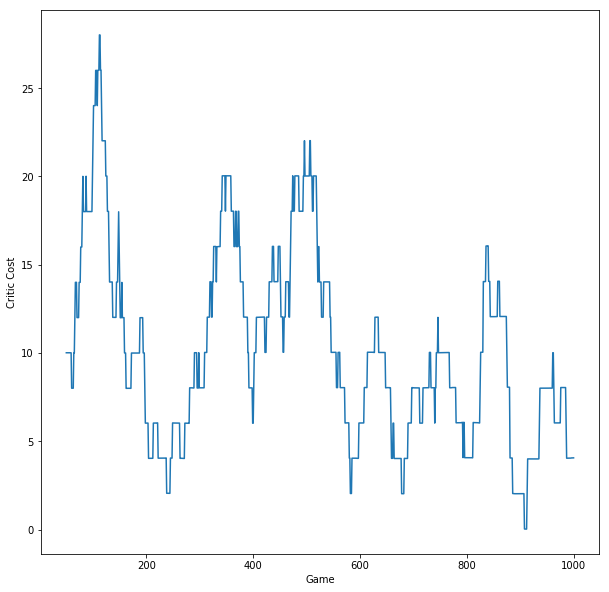

In [15]:
game_df['critic_cost_moving_average'] = game_df['critic_cost'].rolling(window=50).mean()
ax = game_df.plot('game','critic_cost_moving_average', figsize=(10,10), legend=False)
ax.set_xlabel('Game')
ax.set_ylabel('Critic Cost')
plt.show()

## Let's Play!
Let's see how well the Agent performs:

In [16]:
next_state = env.reset()
env.render()
game_over = False
steps = 0
ac.reset_noise()
while not game_over:
    steps += 1
    state = np.copy(next_state)
    action = ac.act(sess, state)
    next_state, _, game_over, _ = env.step(action)
    env.render()
print('Ended after {} steps'.format(steps))

Ended after 526 steps
